# Apprentissage par renforcement

    On crée un environnement composé d'une grille, sur laquelle un agent peut se déplacer avec quatre actions :
    - "droite" ,"gauche" ,"bas"    ,"haut"
    - cet environnement récompense de -500 points lorsqu'on sort de la grille, -50 points lorsqu'on entre dans un piège, et + 1000 points quand on atteint le but.
    
    Il s'agit pour un agent de déterminer une police pour atteindre le but de l'environnement en utilisant les 4 actions. Se notebook a pour vocation à montrer toute la logique de l'apprentissage par renforcement : 
    - la notion de Reward
    - la notion d'étape : je suis dans une position, je fais une action, quel est mon gain ? où est-ce que je me trouve ensuite ?
    - la création d'épisodes
    - la notion de q_function
    - la mise à jour de la q_function 
    - la création d'une policy de déplacement

Aperçu de l'environnement de jeu : 
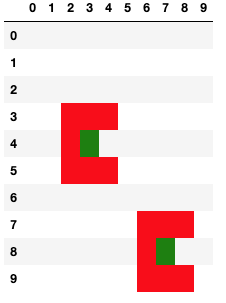

# 1) Classe environnement

In [39]:
import pandas as pd

class environnement:
    """
    Cette classe propose les actions possibles, les buts et les gains / pertes selon les positions.
    """
    actions = ["droite" ,"gauche" ,"bas"    ,"haut"]
    
    x_min, x_max = 0, 10 
    y_min, y_max = 0, 10

    but     = [(7,8) , (3,4)]
    pieges  = [(2,3), (3,3), (4,3),
               (2,4),
               (2,5),(3,5),(4,5),
               (6,8), (7,7), (8,7), 
               (6,7), 
               (6,9), (7,9), (8,9)]

    def get_next_position(self, current_x,current_y, action :str)->(int,int,bool):
        """
        Retourne les nouveaux x,y et si l'agent est sorti de la grille
        """
        # action = "haut" / "bas" ...
        if action in ["droite" ]     : move_y  = +1
        if action in ["gauche" ]     : move_y  = -1
        if action in ["haut", "bas"] : move_y  =  0
            
        if action in ["haut" ]            : move_x  = +1
        if action in ["bas" ]             : move_x  = -1
        if action in ["droite", "gauche"] : move_x  =  0    
            
        next_x          = current_x + move_x
        next_y          = current_y + move_y
        outsider        = False
        if next_x < environnement.x_min           : next_x = environnement.x_min   ; outsider = True
        if next_y < environnement.y_min           : next_y = environnement.y_min   ; outsider = True
        if          environnement.x_max <= next_x : next_x = environnement.x_max-1 ; outsider = True
        if          environnement.y_max <= next_y : next_y = environnement.y_max-1 ; outsider = True
        return next_x, next_y, outsider
    
    def get_reward(self, x, y, outsider):
        if outsider                      : return -500
        if (x,y) in environnement.pieges : return -50
        if (x,y) in environnement.but    : return 100000
        
        return 1
        
    def est_fini(self, x,y):
        return (x,y) in environnement.but
    
    def get_etape(self, current_x, current_y, action):
        """
        Retourne la nouvelle position, le reward et la potentielle déclaration de fin d'épisode.
        """
        next_x, next_y, outsider = self.get_next_position(current_x, current_y, action)
        reward                   = self.get_reward(next_x, next_y, outsider)
        est_fini                 = True if outsider else self.est_fini(next_x, next_y)
        return (next_x, next_y, reward, est_fini)
    
    def create_episode(self, agent, max_iter = 200)->list:
        """
        Retourne une liste de conséquences de décisions selon un emplacement.
        """
        episode  = []
        fini     = False
        while not fini and max_iter>0:
            current_x, current_y         = agent.current_x, agent.current_y
            action                       = agent.get_action()
            next_x, next_y, reward, fini = self.get_etape(current_x, current_y, action)
            
            episode.append({  "current_x"   : current_x, 
                              "current_y"   : current_y, 
                              "action"      : action, 
                              "reward"      : reward, 
                              "fini"        : fini })
            
            agent.current_x = next_x
            agent.current_y = next_y
            max_iter -=1
            
        return episode

# 2) classe agent

In [40]:
class agent:
    def __init__(self):
        self.q_function = {(x,y):{ action : 0 
                                      for action in environnement.actions } for x in range(environnement.x_max)  \
                                                                            for y in range(environnement.y_max)  }
        self.reset_position()
        
        
    def reset_position(self):
        """
        Retourne au point de départ
        """
        import random
        self.current_x = 0
        self.current_y = 0

    def get_action(self):
        """
        Retourne une action aléatoirement choisie
        """
        import random
        return random.choice(environnement.actions)
    
    def get_policy(self):
        """
        Choisi la meilleure action par emplacement.
        """
        policy = {}
        for x_y in self.q_function.keys():
            action_reward       = self.q_function[x_y]
            liste_action_reward = [(action, action_reward[action]) for action in action_reward.keys()]
            sort_actions = sorted(liste_action_reward, key=lambda tuple_: tuple_[1])
            (action, _) = sort_actions[-1]
            policy[x_y] = action
        return policy
        

# 3) Action ! 

## 3.1) on crée les épisodes, et on met à jour la q_function en fonction 

In [41]:
acteur           = agent()
env              = environnement()
alpha            = 0.4
nb_apprentissage = 50000

for Nieme_episode in range(nb_apprentissage):
    acteur.reset_position()
    
    episode     = env.create_episode(acteur)
    last_reward = episode[-1]["reward"]
    
    for  i, dico in enumerate(episode):
        x      = dico["current_x"]
        y      = dico["current_y"]
        action = dico["action"   ]
        
        poids_changement                  = i+1 / len(episode) 
        changement                        = last_reward  * poids_changement
        acteur.q_function[(x,y)][action] += changement

    
    if Nieme_episode%5000 ==0:
        print(Nieme_episode, end=" / ")



0 / 5000 / 10000 / 15000 / 20000 / 25000 / 30000 / 35000 / 40000 / 45000 / 

In [42]:
# question : combien d'épisodes sont créés ? (réponse : nb_apprentssage * max_iter)
# Question : créez une fonction de timing de la fonction create_episode => tracer une courbe du temps de calcul estimé en fonctoin de cela (utiliser timit)

In [43]:
policy = acteur.get_policy()

# 4) afficher le résultat de l'apprentissage

In [44]:
df = pd.DataFrame()
for x in range(10):
    df[x] = [""]*10

In [45]:
panneau = {
    "bas"    : "↑",
    "haut"   : "↓",
    "gauche" : "←",
    "droite" : "→" }
panneau2 = {
    "bas"    : "↑",
    "haut"   : "↓",
    "gauche" : "←",
    "droite" : "→" }

for x in range(environnement.y_max):
    for y in range(environnement.x_max):
        action = policy[(x,y)]
        
        if (x,y) in environnement.but:
            df.iloc[x,y] = "x"
        else:
            df.iloc[x,y] = panneau[action]

In [46]:
df

,0,1,2,3,4,5,6,7,8,9
0,→,↓,↓,↓,↓,↓,↓,↓,↓,↓
1,→,→,↓,↓,↓,↓,↓,←,←,↓
2,→,→,→,↓,↓,↓,←,↓,↓,←
3,→,→,→,→,x,←,←,←,←,←
4,→,→,→,→,↑,↑,↑,↓,←,←
5,→,→,→,↑,↑,↑,←,←,↓,↓
6,→,→,↑,↑,↑,↑,→,↓,↓,←
7,→,→,↑,→,→,↑,→,→,x,←
8,↑,↑,↑,→,↑,→,→,↑,↑,↑
9,↑,→,→,←,↑,↑,↑,→,→,↑


# 5) Exercice :

    - créez un script qui trace le chemin emprunté par cet agent selon un point de départ donné par l'utilisateur

# 5.1) Réponse : 

In [54]:
for i in range(3):
    print("-"*34)
    x_depart = int(input("Quel x de départ"))
    y_depart = int(input("Quel y de départ"))
    
    for i in range(40):
        action = policy[x_depart,y_depart]
        print(action)
        next_x, next_y, sorti  = env.get_next_position(current_x = x_depart, 
                                                       current_y = y_depart, 
                                                       action    = action)
        
        if env.est_fini(x_depart, y_depart):
            print("arrivé !")
            break
        if sorti:
            print("perdu !")
            break
        print(next_x, next_y)
        x_depart, y_depart =    next_x, next_y
        

----------------------------------
Quel x de départ3
Quel y de départ3
droite
3 4
haut
arrivé !
----------------------------------
Quel x de départ3
Quel y de départ0
droite
3 1
droite
3 2
droite
3 3
droite
3 4
haut
arrivé !
----------------------------------
Quel x de départ7
Quel y de départ3
droite
7 4
droite
7 5
bas
6 5
bas
5 5
bas
4 5
bas
3 5
gauche
3 4
haut
arrivé !
